<a href="https://colab.research.google.com/github/DanielDLX/DLfinal/blob/master/RNN_AGnews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 导入包
# transformer提供了一些训练好的模型，可以很方便的使用。
!pip install transformers
import tensorflow as tf
import pandas as pd
import os
import tqdm
# 使用分类的模型，增加了一个head用于分类。
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
% matplotlib inline

tf.__version__

'2.2.0'

In [2]:
# 导入现成的模型和分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4, output_hidden_states=True) # 分类类别数
model.summary()
model.config

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3076      
Total params: 109,485,316
Trainable params: 109,485,316
Non-trainable params: 0
_________________________________________________________________


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

In [3]:
# 简单分类算法
# 把模型改成了最简单的rnn，embedding长度改成了768，因为bert的是768，求余弦相似度的时候需要维度相同
model_compare  = tf.keras.Sequential([
    tf.keras.layers.Embedding(30522, 768),
    tf.keras.layers.SimpleRNN(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4)
])
model_compare.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 768)         23440896  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               114816    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 23,564,228
Trainable params: 23,564,228
Non-trainable params: 0
_________________________________________________________________


In [4]:
# 数据链接，可以在 https://course.fast.ai/datasets 找到。
# agnews数据集，类别，标题，描述。
ag_url = 'https://s3.amazonaws.com/fast-ai-nlp/ag_news_csv.tgz'

In [5]:
# 下载数据，并指定此时数据集的目录
ag_zip_file = tf.keras.utils.get_file(origin=ag_url,fname='ag_news_csv.tgz', extract=True)
base_dir = os.path.join(os.path.dirname(ag_zip_file), 'ag_news_csv')
os.listdir(base_dir)

['readme.txt', 'classes.txt', 'test.csv', 'train.csv']

In [6]:
# 读取数据
# 为了方便测试代码的时候少用几个数据,1000个数据可以让准确率上升到0.68
num = 1000
train = pd.read_csv(os.path.join(base_dir, 'train.csv'), header=None)
train = train.sample(n=num)
print(len(train))
print(train.head())
test = pd.read_csv(os.path.join(base_dir, 'test.csv'), header=None)
test = test.sample(n=num)
print(len(test))
print(test.head())
f = open(os.path.join(base_dir, 'classes.txt'))
classes = f.readlines()
classes = [s.strip() for s in classes]
print(classes)

1000
       0  ...                                                  2
45682  3  ...  LONDON, Sept 30 (AFP) - Oil prices resumed the...
25180  2  ...  AP - Tampa Bay Buccaneers receiver Joey Gallow...
36641  3  ...  WASHINGTONCrude futures prices surged above \$...
11832  3  ...  Shares in dairy giant Dairy Crest Group have f...
51336  2  ...  Australia has made a slow but solid start to t...

[5 rows x 3 columns]
1000
      0  ...                                                  2
6934  3  ...  New figures show Japan's economy is barely sta...
7179  1  ...   SEOUL (Reuters) - North Korea will not disman...
4454  2  ...  SIR ALEX FERGUSON was pelted with food and pea...
3191  1  ...  Israeli jets force a flight to Tel Aviv to lan...
4442  4  ...  I.B.M. plans to begin releasing a monthly repo...

[5 rows x 3 columns]
['World', 'Sports', 'Business', 'Sci/Tech']


In [7]:
# 预处理数据
# 按照上面的例子把数据集中的文本进行分词处理，并且得到对应的labels。
max_length = 256
max_length_temp = max_length - 2
train_ids = []
test_ids = []
for i in tqdm.notebook.trange(train.shape[0]):
  if len(train[2][train[2].index[i]]) > max_length_temp:
    train_ids.append(tokenizer.encode(text=train[2][train[2].index[i]][0 : max_length_temp], padding='max_length', max_length=max_length, return_tensors="tf"))
  else:
    train_ids.append(tokenizer.encode(text=train[2][train[2].index[i]], padding='max_length', max_length=max_length, return_tensors="tf"))
for i in tqdm.notebook.trange(test.shape[0]):
  if len(test[2][test[2].index[i]]) > max_length_temp:
    test_ids.append(tokenizer.encode(text=test[2][test[2].index[i]][0 : max_length_temp], padding='max_length', max_length=max_length, return_tensors="tf"))
  else:
    test_ids.append(tokenizer.encode(text=test[2][test[2].index[i]], padding='max_length', max_length=max_length, return_tensors="tf"))
train_labels = train[0].values - 1
test_labels = test[0].values - 1

In [8]:
# 把数据转成tensorflow张量
# train_ids是tf.Tensor组成得列表，所以用concat组合一下就行
train_ids = tf.concat(train_ids, 0)
# 把train_mask初始化为1，然后把train_ids等于0（PAD的部分）对应的值赋为0
train_mask = tf.ones(train_ids.shape)
train_mask = tf.where(tf.math.greater(train_ids, 0), train_mask, 0)
# labels本身是numpy数组，转为tf.Tensor
train_labels = tf.convert_to_tensor(train_labels)

# 测试集的处理同理test
test_ids = tf.concat(test_ids, 0)
test_mask = tf.ones(test_ids.shape)
test_mask = tf.where(tf.math.greater(test_ids, 0), test_mask, 0)
test_labels = tf.convert_to_tensor(test_labels)

In [9]:
print(train_ids[0])
print(train_mask[0])
print(train_labels[0])

tf.Tensor(
[  101  2414  1010 17419  2382  1006 21358  2361  1007  1011  3514  7597
  7943  2037  2233  2875  2753  6363  1999  2047  2259  2006  9432  2130
  2004  3521  7566  2020  2275  2000 13746  1999  2350  3135  7387  1998
  2206  2019  9223  4125  1999  2149 13587 12235  3111  1012   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

In [10]:
# 训练参数
epochs = 5
batch_size = 16
validation_rate = 0.1

In [11]:
# 模型编译
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model_compare.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [12]:
# 模型训练
history = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=None,
     shuffle=True)

Epoch 1/5
63/63 [==============================] - 52s 818ms/step - loss: 0.8101 - accuracy: 0.7370
Epoch 2/5
63/63 [==============================] - 52s 825ms/step - loss: 0.2666 - accuracy: 0.9230
Epoch 3/5
63/63 [==============================] - 52s 825ms/step - loss: 0.1400 - accuracy: 0.9590
Epoch 4/5
63/63 [==============================] - 52s 825ms/step - loss: 0.0680 - accuracy: 0.9860
Epoch 5/5
63/63 [==============================] - 52s 826ms/step - loss: 0.0315 - accuracy: 0.9940


In [13]:
history_compare = model_compare.fit(
    x=[train_ids, train_mask],
    y=train_labels,
    batch_size=batch_size, 
    epochs=epochs,
    verbose=1,
    callbacks=None,
    shuffle=True
)

Epoch 1/5
63/63 [==============================] - 25s 396ms/step - loss: 1.3960 - accuracy: 0.6200
Epoch 2/5
63/63 [==============================] - 24s 386ms/step - loss: 1.3895 - accuracy: 0.2650
Epoch 3/5
63/63 [==============================] - 25s 393ms/step - loss: 1.3912 - accuracy: 0.2480
Epoch 4/5
63/63 [==============================] - 24s 380ms/step - loss: 1.3862 - accuracy: 0.2760
Epoch 5/5
63/63 [==============================] - 24s 381ms/step - loss: 1.3893 - accuracy: 0.2680


In [14]:
# 模型测试
model.evaluate(x=[test_ids, test_mask],
        y=test_labels, 
        batch_size=4, 
        verbose=1)

250/250 [==============================] - 18s 71ms/step - loss: 0.5537 - accuracy: 0.8630


[0.5536646246910095, 0.8629999756813049]

In [15]:
model_compare.evaluate(x=[test_ids, test_mask],
        y=test_labels, 
        batch_size=4, 
        verbose=1)

250/250 [==============================] - 5s 21ms/step - loss: 1.3878 - accuracy: 0.2500


[1.3878474235534668, 0.25]

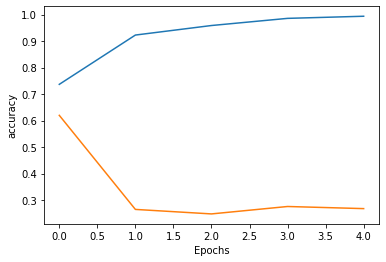

In [16]:
# 画图
def plot_graphs(history,history_compare, metric):
  plt.plot(history.history[metric])
  plt.plot(history_compare.history[metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.show()
plot_graphs(history, history_compare, 'accuracy')

In [22]:
# 得到RNN模型embedding的方法，get embedding层后，输入词的id，得到embeding
embedding_compare = model_compare.get_layer('embedding')
avg_pool1 = tf.keras.layers.AveragePooling2D(pool_size=(256, 1))
seq_emb = embedding_compare(train_ids[0])
print(seq_emb)
seq_avg = avg_pool1(seq_emb.resize([1,1,256,768]))
print(seq_avg)

tf.Tensor(
[[ 0.04764335 -0.03619531  0.04308876 ... -0.0333138   0.01262991
  -0.02319496]
 [ 0.04406951  0.01749485  0.02747624 ...  0.03371483  0.00931129
  -0.01300792]
 [ 0.02435975  0.02004764  0.04543563 ... -0.00318722  0.02973461
   0.02629073]
 ...
 [ 0.01821887 -0.03046171  0.0329073  ... -0.03623446  0.01459374
  -0.03085981]
 [ 0.01821887 -0.03046171  0.0329073  ... -0.03623446  0.01459374
  -0.03085981]
 [ 0.01821887 -0.03046171  0.0329073  ... -0.03623446  0.01459374
  -0.03085981]], shape=(256, 768), dtype=float32)


AttributeError: ignored

In [ ]:
class_embedding_compare = tf.zeros.([4,768])
for i in tqdm.notebook.trange(train_ids.size[0]):
  seq_embeds = embedding_compare(train_ids[i])

In [18]:
# 获得bert Embedding的方式，这里得到是整个embedding张量
embeddings = model.get_layer('bert').embeddings.word_embeddings

# 定义函数：通过词id 得到embedding
def get_embedding(input_ids, embeddings=embeddings):
  embeds = tf.gather(embeddings, input_ids)
  return embeds

In [19]:
get_embedding([10,20,30])

<tf.Tensor: shape=(3, 768), dtype=float32, numpy=
array([[-0.01138028, -0.05855127, -0.03583531, ..., -0.01770614,
        -0.03011706, -0.00614887],
       [-0.0215261 , -0.04995545, -0.03237724, ..., -0.01600818,
        -0.0437283 , -0.01367573],
       [-0.01374775, -0.06106352, -0.03362556, ..., -0.02177956,
        -0.03429128, -0.01755657]], dtype=float32)>